In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import optimizers
from keras.models import load_model
from sklearn.metrics import mean_absolute_error
import os


Using TensorFlow backend.


In [2]:
############ BiLSTM functions
# generate input and output pairs of sequences
def create_sequences_BiLSTM(data, length, output):
    nsignals = data.shape[1]
    siglen = data.shape[0]
    sampX=[]
    sampy=[]
    indx = siglen - output - length
    for j in range(nsignals):
        sig = data[:,j]
        for i in range(indx):
            tempX = sig[i:length+i]
            tempy = sig[i+length:length+i+output]
            sampX.append(tempX)
            sampy.append(tempy)
    nsamples = len(sampX)        
    X = np.array(sampX).reshape(nsamples, length, 1)
    y = np.array(sampy).reshape(nsamples, output, 1) 
    return X, y  

#Split training and test datasets
def define_test_dataset_BiLSTM(X, y, n_patterns, ntestsigs):
    testindex = int(np.floor(ntestsigs*n_patterns))
    X_train = X[:-testindex,:,:]
    y_train = y[:-testindex,:,:]
    X_test = X[-testindex:,:,:]
    y_test = y[-testindex:,:,:]
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, y_train, X_test, y_test

def MASE(realData, predictedData):
    """ Regression Error metric = mean absolute scaled error (MASE)"""
    temp = realData.shape
    datlen = temp[1]-1
    a1 = np.reshape(realData[0,1:],[datlen,1])
    a2 = np.reshape(realData[0,:-1],[datlen,1])
    maseErr = mean_absolute_error(a1,predictedData[0,1:])/mean_absolute_error(a1,a2)
    return maseErr


In [3]:
############## Load LSTM datasets
###############################

ndataset = 6
os.chdir('../../training/MHD/BiLSTM/')
length = 10
output = length

############# POD mode 1
fM1 = h5py.File('PODm1_MHD32BoxALL.mat')
dataM1 = fM1.get('data')
dataM1 = np.transpose(dataM1)

# configure problem
nsignals = dataM1.shape[1]
siglen = dataM1.shape[0]

# Extract sequences
inputdata = dataM1[:,0:ndataset]
XM1, yM1 = create_sequences_BiLSTM(inputdata, length, output)
ntestpatterns = siglen - length - output
ntestsigs = 1
X_trainM1, y_trainM1, X_testM1_B, y_testM1_B = define_test_dataset_BiLSTM(XM1, yM1, ntestpatterns, ntestsigs)
os.chdir('../../../analysis/MHD/')

############# POD mode 2
os.chdir('../../training/MHD/BiLSTM/')

fM2 = h5py.File('PODm2_MHD32BoxALL.mat')
dataM2 = fM2.get('data')
dataM2 = np.transpose(dataM2)

# Extract sequences
inputdata = dataM2[:,0:ndataset]
XM2, yM2 = create_sequences_BiLSTM(inputdata, length, output)
ntestpatterns = siglen - length - output
ntestsigs = 1
X_trainM2, y_trainM2, X_testM2_B, y_testM2_B = define_test_dataset_BiLSTM(XM2, yM2, ntestpatterns, ntestsigs)
os.chdir('../../../analysis/MHD/')

############# POD mode 3
os.chdir('../../training/MHD/BiLSTM/')

fM3 = h5py.File('PODm3_MHD32BoxALL.mat')
dataM3 = fM3.get('data')
dataM3 = np.transpose(dataM3)

# Extract sequences
inputdata = dataM3[:,0:ndataset]
XM3, yM3 = create_sequences_BiLSTM(inputdata, length, output)
ntestpatterns = siglen - length - output
ntestsigs = 1
X_trainM3, y_trainM3, X_testM3_B, y_testM3_B = define_test_dataset_BiLSTM(XM3, yM3, ntestpatterns, ntestsigs)
os.chdir('../../../analysis/MHD/')

############# POD mode 4
os.chdir('../../training/MHD/BiLSTM/')

fM4 = h5py.File('PODm4_MHD32BoxALL.mat')
dataM4 = fM4.get('data')
dataM4 = np.transpose(dataM4)

# Extract sequences
inputdata = dataM4[:,0:ndataset]
XM4, yM4 = create_sequences_BiLSTM(inputdata, length, output)
ntestpatterns = siglen - length - output
ntestsigs = 1
X_trainM4, y_trainM4, X_testM4_B, y_testM4_B = define_test_dataset_BiLSTM(XM4, yM4, ntestpatterns, ntestsigs)
os.chdir('../../../analysis/MHD/')

############# POD mode 5
os.chdir('../../training/MHD/BiLSTM/')

fM5 = h5py.File('PODm5_MHD32BoxALL.mat')
dataM5 = fM5.get('data')
dataM5 = np.transpose(dataM5)

# Extract sequences
inputdata = dataM5[:,0:ndataset]
XM5, yM5 = create_sequences_BiLSTM(inputdata, length, output)
ntestpatterns = siglen - length - output
ntestsigs = 1
X_trainM5, y_trainM5, X_testM5_B, y_testM5_B= define_test_dataset_BiLSTM(XM5, yM5, ntestpatterns, ntestsigs)
print(X_testM5_B.shape)
os.chdir('../../../analysis/MHD/')


(1004, 10, 1)


In [4]:
# Load finalized LSTM models
os.chdir('../../training/MHD/BiLSTM/')

model = load_model('MHD32boxROMncell250lr0.0001bs32c5.h5')
print('Loaded POD model')


Loaded POD model


Time Index is 764
Done


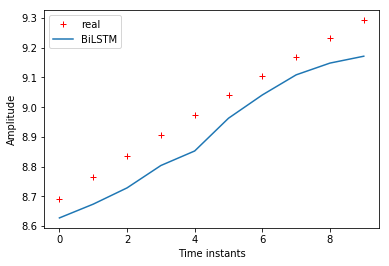

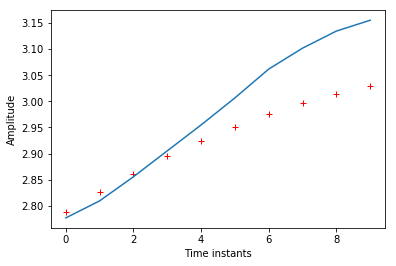

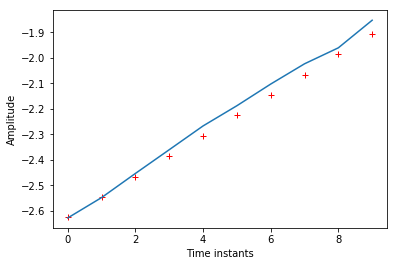

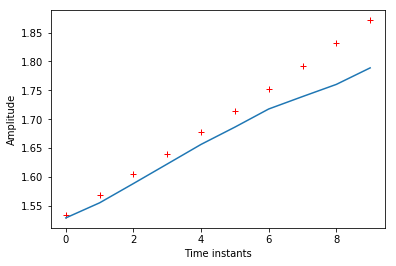

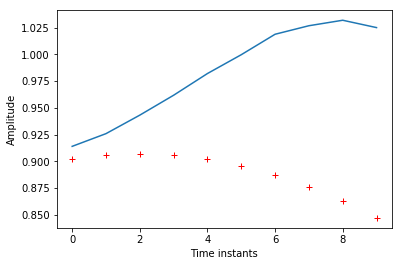

In [5]:
#### BiLSTM ROM prediction time index for all POD modes

# EVALUATE: Predict future instance of POD coeffs and compare with truth value on test signal
nHorizon = 1 # no. of sequences you want to cyclically predict
#timeIndex = np.random.randint(0, ntestpatterns + 1)
timeIndex = 764
print('Time Index is', timeIndex)

############# POD mode 1

##### Cyclic prediction
signalM1_B = np.zeros((1,10))
trueSignalM1_B = np.zeros((1,10))
datainputM1 = X_testM1_B[timeIndex ,:,:]
for i in range(0,nHorizon):
    datainputM1 = datainputM1.reshape(1, length, 1)
    predictedM1 = model.predict(datainputM1, verbose=0)
    signalM1_B = np.append(signalM1_B, predictedM1)
    expected = y_testM1_B[timeIndex + i*10,:]
    trueSignalM1_B = np.append(trueSignalM1_B, expected)
    datainputM1 = np.transpose(predictedM1)  

    
############# POD mode 2

##### Cyclic prediction
signalM2_B = np.zeros((1,10))
trueSignalM2_B = np.zeros((1,10))
datainputM2 = X_testM2_B[timeIndex ,:,:]
for i in range(0,nHorizon):
    datainputM2 = datainputM2.reshape(1, length, 1)
    predictedM2 = model.predict(datainputM2, verbose=0)
    signalM2_B = np.append(signalM2_B, predictedM2)
    expected = y_testM2_B[timeIndex + i*10,:]
    trueSignalM2_B = np.append(trueSignalM2_B, expected)
    datainputM2 = np.transpose(predictedM2)     

    
############# POD mode 3

##### Cyclic prediction
signalM3_B = np.zeros((1,10))
trueSignalM3_B = np.zeros((1,10))
datainputM3 = X_testM3_B[timeIndex ,:,:]
for i in range(0,nHorizon):
    datainputM3 = datainputM3.reshape(1, length, 1)
    predictedM3 = model.predict(datainputM3, verbose=0)
    signalM3_B = np.append(signalM3_B, predictedM3)
    expected = y_testM3_B[timeIndex + i*10,:]
    trueSignalM3_B = np.append(trueSignalM3_B, expected)
    datainputM3 = np.transpose(predictedM3)    
    
    
############# POD mode 4

##### Cyclic prediction
signalM4_B = np.zeros((1,10))
trueSignalM4_B = np.zeros((1,10))
datainputM4 = X_testM4_B[timeIndex ,:,:]
for i in range(0,nHorizon):
    datainputM4 = datainputM4.reshape(1, length, 1)
    predictedM4 = model.predict(datainputM4, verbose=0)
    signalM4_B = np.append(signalM4_B, predictedM4)
    expected = y_testM4_B[timeIndex + i*10,:]
    trueSignalM4_B = np.append(trueSignalM4_B, expected)
    datainputM4 = np.transpose(predictedM4)     

    
############# POD mode 5

##### Cyclic prediction
signalM5_B = np.zeros((1,10))
trueSignalM5_B = np.zeros((1,10))
datainputM5 = X_testM5_B[timeIndex ,:,:]
for i in range(0,nHorizon):
    datainputM5 = datainputM5.reshape(1, length, 1)
    predictedM5 = model.predict(datainputM5, verbose=0)
    signalM5_B = np.append(signalM5_B, predictedM5)
    expected = y_testM5_B[timeIndex + i*10,:]
    trueSignalM5_B = np.append(trueSignalM5_B, expected)
    datainputM5 = np.transpose(predictedM5)    
    
    
print('Done')

############# Plot ALL predicted coefficients

plt.figure(1)
plt.plot(trueSignalM1_B[10:],'r+', label='real')
plt.plot(signalM1_B[10:], label='BiLSTM')
plt.legend()
plt.xlabel('Time instants')
plt.ylabel('Amplitude')
plt.show()

plt.figure(2)
plt.plot(trueSignalM2_B[10:],'r+', label='real')
plt.plot(signalM2_B[10:], label='BiLSTM')
#plt.legend()
plt.xlabel('Time instants')
plt.ylabel('Amplitude')
plt.show()

plt.figure(3)
plt.plot(trueSignalM3_B[10:],'r+', label='real')
plt.plot(signalM3_B[10:], label='BiLSTM')
#plt.legend()
plt.xlabel('Time instants')
plt.ylabel('Amplitude')
plt.show()

plt.figure(4)
plt.plot(trueSignalM4_B[10:],'r+', label='real')
plt.plot(signalM4_B[10:], label='BiLSTM')
#plt.legend()
plt.xlabel('Time instants')
plt.ylabel('Amplitude')
plt.show()

plt.figure(5)
plt.plot(trueSignalM5_B[10:],'r+', label='real')
plt.plot(signalM5_B[10:], label='BiLSTM')
#plt.legend()
plt.xlabel('Time instants')
plt.ylabel('Amplitude')
plt.show()

In [6]:
# Plot error for all predictions in a model
from sklearn.metrics import mean_absolute_error
%matplotlib inline  

############# POD mode 1
errTotM1 = []

for idx in range(ntestpatterns):
    datainput = X_testM1_B[idx ,:,:]
    datainput = datainput.reshape(1, length, 1)
    realdata = y_testM1_B[idx ,:]
    realdata = np.transpose(realdata).reshape(1,output)
    predicted = model.predict(datainput, verbose=0)
    err = MASE(realdata, predicted)
    errTotM1.append(err)

print('Computed PODm1 err Total Error')

############# POD mode 2
errTotM2 = []

for idx in range(ntestpatterns):
    datainput = X_testM2_B[idx ,:,:]
    datainput = datainput.reshape(1, length, 1)
    realdata = y_testM2_B[idx ,:]
    realdata = np.transpose(realdata).reshape(1,output)
    predicted = model.predict(datainput, verbose=0)
    err = MASE(realdata, predicted)
    errTotM2.append(err)

print('Computed PODm2 err Total Error')

############# POD mode 3
errTotM3 = []

for idx in range(ntestpatterns):
    datainput = X_testM3_B[idx ,:,:]
    datainput = datainput.reshape(1, length, 1)
    realdata = y_testM3_B[idx ,:]
    realdata = np.transpose(realdata).reshape(1,output)
    predicted = model.predict(datainput, verbose=0)
    err = MASE(realdata, predicted)
    errTotM3.append(err)

print('Computed PODm3 err Total Error')


############# POD mode 4
errTotM4 = []

for idx in range(ntestpatterns):
    datainput = X_testM4_B[idx ,:,:]
    datainput = datainput.reshape(1, length, 1)
    realdata = y_testM4_B[idx ,:]
    realdata = np.transpose(realdata).reshape(1,output)
    predicted = model.predict(datainput, verbose=0)
    err = MASE(realdata, predicted)
    errTotM4.append(err)

print('Computed PODm4 err Total Error')

############# POD mode 5
errTotM5 = []

for idx in range(ntestpatterns):
    datainput = X_testM5_B[idx ,:,:]
    datainput = datainput.reshape(1, length, 1)
    realdata = y_testM5_B[idx ,:]
    realdata = np.transpose(realdata).reshape(1,output)
    predicted = model.predict(datainput, verbose=0)
    err = MASE(realdata, predicted)
    errTotM5.append(err)

print('Computed PODm5 err Total Error')

Computed PODm1 err Total Error
Computed PODm2 err Total Error
Computed PODm3 err Total Error
Computed PODm4 err Total Error
Computed PODm5 err Total Error


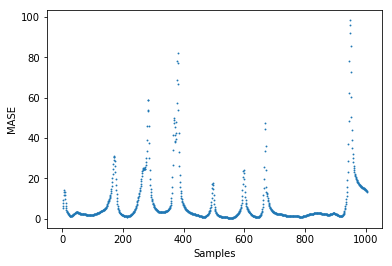

Mean MASE is 7.70927693966
STD of MASE is 12.5938321777


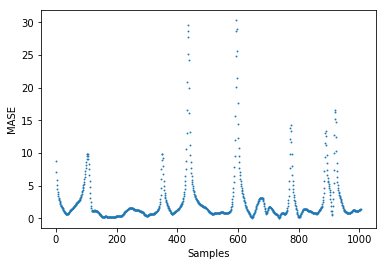

Mean MASE is 2.62821721939
STD of MASE is 3.88926053679


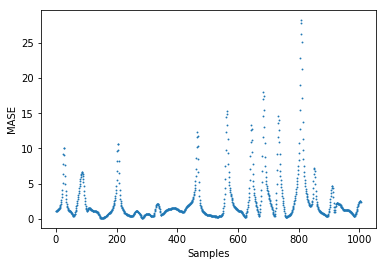

Mean MASE is 2.5441708537
STD of MASE is 3.41678477179


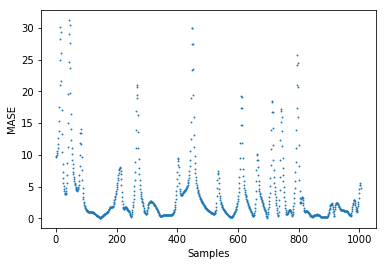

Mean MASE is 3.89803159219
STD of MASE is 5.2290076947


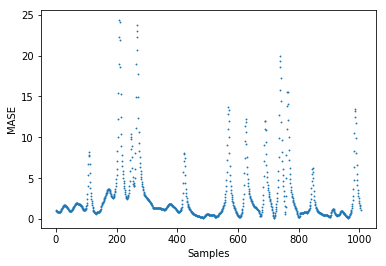

Mean MASE is 2.80070102277
STD of MASE is 3.66116369256


In [7]:
# plot RMSE for all POD modes

xaxis = np.linspace(1,ntestpatterns, ntestpatterns)

plt.scatter(xaxis, errTotM1, s=0.75)
plt.xlabel('Samples')
plt.ylabel('MASE')
plt.show()
print('Mean MASE is', np.mean(errTotM1))
print('STD of MASE is', np.std(errTotM1))

plt.scatter(xaxis, errTotM2, s=0.75)
plt.xlabel('Samples')
plt.ylabel('MASE')
plt.show()
print('Mean MASE is', np.mean(errTotM2))
print('STD of MASE is', np.std(errTotM2))

plt.scatter(xaxis, errTotM3, s=0.75)
plt.xlabel('Samples')
plt.ylabel('MASE')
plt.show()
print('Mean MASE is', np.mean(errTotM3))
print('STD of MASE is', np.std(errTotM3))

plt.scatter(xaxis, errTotM4, s=0.75)
plt.xlabel('Samples')
plt.ylabel('MASE')
plt.show()
print('Mean MASE is', np.mean(errTotM4))
print('STD of MASE is', np.std(errTotM4))

plt.scatter(xaxis, errTotM5, s=0.75)
plt.xlabel('Samples')
plt.ylabel('MASE')
plt.show()
print('Mean MASE is', np.mean(errTotM5))
print('STD of MASE is', np.std(errTotM5))